**Notes**:
* Feel free to add cells as you need them.
* Keep your code clean and readable.
* Comments included in this document are just to summarize the question. For full details make sure you read the assignment pdf thoroughly.
* Don't forget to rename the file when you finish

# EECS 461/ECE 523  | Assignment 3

In [31]:
# IMPORTING EVERYTHING I NEED
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [32]:
# WRITING A FUNCTION WHICH WILL GIVE ME THE DATAFRAME I NEED SO I CAN USE IT FOR TRAINING AND TEST SET
def x_e_and_y(filename):
    df = pd.DataFrame(data = pd.read_csv(filename))
    
    df = df.dropna(subset=["price"]).reset_index(drop=True)
    
    train_x_a = df.iloc[:,:-1] 
    
    train_y = pd.DataFrame(df.iloc[:,-1])
    
    
    nan_columns = train_x_a.columns[train_x_a.isna().any()].tolist()
    
    train_x_b = train_x_a.fillna(train_x_a.mean()) 
    
    categorical_columns = train_x_b.select_dtypes(["object"]).columns.tolist()

    encoder = OneHotEncoder()
    encodedColumns = encoder.fit_transform(train_x_b[categorical_columns]).toarray()
    encodedDataFrame = pd.DataFrame(encodedColumns,columns = encoder.get_feature_names())
    
    
    numericalColumns = train_x_b.select_dtypes(["float64"]).columns.tolist()
    numericalDataFrame = pd.DataFrame(train_x_b[numericalColumns],columns = numericalColumns)
    
    
    train_x_d = encodedDataFrame.join(numericalDataFrame)
    train_x_d = train_x_d.fillna(train_x_d.mean())


    Std_Sca = StandardScaler()
    train_x_e = Std_Sca.fit_transform(train_x_d)
    
    train_x_e = pd.DataFrame(train_x_e,columns=train_x_d.columns)

    return train_x_e,train_y


train_x_e,train_y = x_e_and_y('training.csv')
test_x , test_y = x_e_and_y('test.csv')

## KNN REGGRESSOR TO PREDICT CAR PRICES 

### a) Training Vs Validation Plot:

In [33]:
# SPLITING OUR DATA INTO TRAIN AND VALIDATION SETS
train_split_x , val_split_x , train_split_y , val_split_y = train_test_split(train_x_e,train_y, test_size=0.2,random_state=0)

In [34]:
knn_training_errors = []
knn_validation_errors = []

In [35]:
# STARTING A LOOP FOR 30 STEPS AND USING THEM AS N OF KNN. FITTING THE MODEL AND TESTING THE TRAIN AND VAL ERRORS AND ADDING
# THEM TO OUR LIST OF ERRORS
for i in range(30):
    i = i+1
    
    knn_reg = KNeighborsRegressor(n_neighbors=i)
    knn_reg_fit = knn_reg.fit(train_split_x,train_split_y)
    
    knn_reg_pred_train = knn_reg.predict(train_split_x)
    knn_reg_pred_val = knn_reg.predict(val_split_x)
    
    knn_training_error = mean_squared_error(knn_reg_pred_train,train_split_y)
    
    knn_validation_error = mean_squared_error(knn_reg_pred_val,val_split_y)
    
    knn_training_errors.append(knn_training_error)
    knn_validation_errors.append(knn_validation_error)


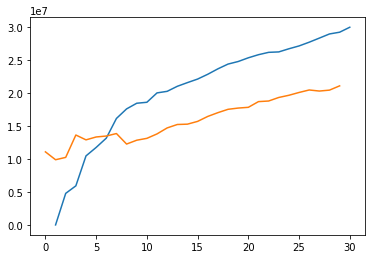

In [36]:
# PLOTTING THE ERRORS 

# BLUE LINE FOR TRAINING AND ORANGE LINE FOR VALIDATION ERRORS

knn_n = [i+1 for i in range(30)]

plt.plot(knn_n,knn_training_errors,knn_validation_errors)


### b) Test your model:

In [37]:
# IN HERE, I AM CHECKING VALIDATION ERRORS FOR EACH K VALUE AND SELECTING THE K VALUE WHICH GIVES THE MINIMUM VAL ERROR

errors = []
for i in range(len(knn_training_errors)):
        errors.append((knn_validation_errors[i],i+1))
errors.sort()
best_n = errors[0][1]
best_n

2

In [38]:
# CREATING THE MODEL WITH BEST K VALUE AND FITTING IT THEN PREDICTING AND FINALLY PRINTING OUR MSE ERROR
best_knn = KNeighborsRegressor(n_neighbors=best_n).fit(train_split_x,train_split_y)

In [39]:
knn_preds = best_knn.predict(test_x)

In [40]:
knn_mse = mean_squared_error(knn_preds,test_y)
print(knn_mse)

36846783.1328125


## DECISION TREE REGRESSOR TO PREDICT CAR PRICES

### c) Grid Search to find best model:

In [41]:
# GIVING THE PARAMETERS WHICH ARE GIVING BY INSTRUCTRE AND DEFINING THE MODEL WITH 0 RANDOM_STATE VALUE AND CALLING OUR GRID SEARCH
parameters = [{"max_depth" : [None, 1, 5, 10],
               "min_samples_split" :[0.01, 0.05, 0.1, 0.3],
               "max_features": ["auto", "sqrt", "log2"],
               "max_leaf_nodes": [10, 50, 100, 250]}]


dt_Reg = DecisionTreeRegressor(random_state=0)

decision_tree_grid = GridSearchCV(estimator = dt_Reg, param_grid= parameters, cv=5,scoring='neg_mean_squared_error')

decision_tree_grid_fit = decision_tree_grid.fit(train_x_e,train_y)

In [42]:
# PRINTING OUT THE BEST PARAMETERS FOR THIS GRID SEARCH
decision_tree_grid.best_params_

{'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'min_samples_split': 0.1}

In [43]:
# PRINTING OUT OUR BEST SCORE
abs(decision_tree_grid.best_score_)

9771397.014533112

### d) Test your model:

In [44]:
# CREATING MODEL WITH BEST PARAMETERS AND TESTING ON OUR TEST SET AND PRINTING OUR TEST MSE FOR THIS MODEL 
best_tree = DecisionTreeRegressor(max_depth = 5, max_features= 'auto', max_leaf_nodes = 10, min_samples_split =  0.1,
                                  random_state = 0)
best_tree_fit = best_tree.fit(train_x_e,train_y)

In [45]:
tree_preds = best_tree.predict(test_x)

In [46]:
tree_mse = mean_squared_error(tree_preds,test_y)
print(tree_mse)

38622220.42485659


## ENSEMBLE BAGGING REGRESSOR TO PREDICT CAR PRICES

### e) Grid Search to find best model:

In [47]:
# SAME PROCESSES AS WE DID ON PREVIOUS CHAPTER WITH DIFFERENT PARAMETERS AND REST IS SAME
parameters = [{"base_estimator": [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor(random_state=0)],
               "n_estimators":[25, 50, 100, 250], "bootstrap_features": [False, True], "random_state" : [0]}]
bag_reg = BaggingRegressor()
bag_grid = GridSearchCV(estimator = bag_reg , param_grid = parameters, cv=5 ,scoring = "neg_mean_squared_error")
bag_grid_fit = bag_grid.fit(train_x_e,train_y)

In [48]:
bag_grid.best_params_

{'base_estimator': DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=0, splitter='best'),
 'bootstrap_features': True,
 'n_estimators': 25,
 'random_state': 0}

In [49]:
abs(bag_grid.best_score_)

8075642.4664184

### f) Test your model:

In [50]:
# SAME PROCESSES AS WE DID ON PREVIOUS CHAPTER WITH DIFFERENT PARAMETERS AND REST IS SAME

best_bag = BaggingRegressor(DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                                                  max_leaf_nodes=None, min_impurity_decrease=0.0,
                                                  min_impurity_split=None, min_samples_leaf=1,
                                                  min_samples_split=2, min_weight_fraction_leaf=0.0,
                                                  presort=False, random_state=0, splitter='best'),
                            bootstrap_features = True, 
                            n_estimators = 25, 
                            random_state = 0)

best_bag_fit = best_bag.fit(train_x_e,train_y)

In [51]:
bag_preds = best_bag.predict(test_x)

In [52]:
bag_mse = mean_squared_error(bag_preds,test_y)
print(bag_mse)

25970112.527521636


## RANDOM FOREST REGRESSOR TO PREDICT CAR PRICES

### g) Grid Search to find best model:

In [53]:
# SAME PROCESSES AS WE DID ON PREVIOUS CHAPTER WITH DIFFERENT PARAMETERS AND REST IS SAME

parameters = [{"n_estimators" : [25, 50, 100, 250], "max_depth" : [None, 1, 5, 10],"random_state":[0]}]

rf_reg = RandomForestRegressor()

random_forest_grid = GridSearchCV(estimator=rf_reg , param_grid = parameters, cv= 5, scoring = "neg_mean_squared_error")
random_forest_grid_fit = random_forest_grid.fit(train_x_e,train_y)

In [54]:
random_forest_grid.best_params_

{'max_depth': 5, 'n_estimators': 50, 'random_state': 0}

In [55]:
abs(random_forest_grid.best_score_)

8050778.6728321295

### h) Test your model:

In [56]:
best_random_forest = RandomForestRegressor(max_depth=5,n_estimators=50,random_state=0)
best_random_forest_fit = best_random_forest.fit(train_x_e,train_y)

In [57]:
random_forest_preds = best_random_forest.predict(test_x)

In [58]:
random_forest_mse = mean_squared_error(random_forest_preds,test_y)
print(random_forest_mse)

33330466.85609337


### i) Feature Importances:

In [59]:
# MATCHING THE IMPORTANCES AND FEATURE NAMES AND ADDING THEM IN OUT LIST AND SORTING IT AND PRINGTING OUR 3 MOST IMPORTANT FEATURES
feature_importance = []
for name, score in zip(train_x_e.columns, best_random_forest.feature_importances_):
    feature_importance.append((score, name))
feature_importance.sort()
feature_importance = feature_importance[::-1]

In [60]:
top_3_rf_features = [i[1] for i in feature_importance[0:3]]
print(top_3_rf_features)

['enginesize', 'curbweight', 'citympg']
